In [ ]:
# AQI Forecasting System (Mumbai)

#This notebook builds a scalable AQI forecasting system using historical AQI data
#from multiple monitoring stations in Mumbai.

#Key points:
#- Single global LSTM model
#- 7-day AQI prediction

In [2]:
import pandas as pd
data = pd.read_csv("../data/raw/malad.csv")
data.head()

,date,pm25,pm10,o3,no2,so2,co
0,2026/1/1,80,78,63,20,5,4
1,2026/1/2,116,86,54,25,6,5
2,2026/1/3,117,103,48,26,5,7
3,2026/1/4,156,102,76,26,7,7
4,2026/1/5,152,113,76,34,7,8


In [4]:
#getting to know the dataset and handling type conversion
data.info()
data.columns = data.columns.str.strip()
num_cols = ["pm25","pm10","o3","no2","so2","co"]
data[num_cols] = data[num_cols].apply(pd.to_numeric, errors="coerce")
data["date"] = pd.to_datetime(data["date"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1326 non-null   datetime64[ns]
 1   pm25    1074 non-null   float64       
 2   pm10    1149 non-null   float64       
 3   o3      1273 non-null   float64       
 4   no2     1015 non-null   float64       
 5   so2     1123 non-null   float64       
 6   co      1007 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 72.6 KB


In [7]:
#handling null values by dropping important ones & interpolating others
data = data.dropna(subset=["pm25"])
num_cols = ["pm10","o3","no2","so2","co"]
data = data.sort_values("date")
data = data.set_index("date")
data[num_cols] = data[num_cols].interpolate(method="time")
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1074 entries, 2021-12-28 to 2026-01-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm25    1074 non-null   float64
 1   pm10    1074 non-null   float64
 2   o3      1074 non-null   float64
 3   no2     1074 non-null   float64
 4   so2     1074 non-null   float64
 5   co      1074 non-null   float64
dtypes: float64(6)
memory usage: 58.7 KB


In [8]:
data["month"] = data.index.month_name()

In [10]:
data = data.sort_values("date", ascending=False)
data.head()

,pm25,pm10,o3,no2,so2,co,month
date,,,,,,,
2026-01-06,154.0,113.0,76.0,34.0,7.0,8.0,January
2026-01-05,152.0,113.0,76.0,34.0,7.0,8.0,January
2026-01-04,156.0,102.0,76.0,26.0,7.0,7.0,January
2026-01-03,117.0,103.0,48.0,26.0,5.0,7.0,January
2026-01-02,116.0,86.0,54.0,25.0,6.0,5.0,January


In [18]:
#calculating all-over aqi using linear interpolating => breakpoint comparison according to CPCB and assigning based on max sub-index
#c_high/low = low and high breakpoints of the concentration (value) and i_high/low = the index the conc corresponds to
#the breakpoints of the pollutants to be defined individually.
def calc_subindex(val,breakpoints):
    for bp in breakpoints:
        if bp["c_low"] <= val <= bp["c_high"]:
            return ((bp["i_high"]-bp["i_low"])/(bp["c_high"]-bp["c_low"]))*(val-bp["c_low"])+bp["i_low"]

In [16]:
#all breakpoints
pm25_breakpoints = [
    {"c_low": 0,   "c_high": 30,  "i_low": 0,   "i_high": 50},
    {"c_low": 30,  "c_high": 60,  "i_low": 50,  "i_high": 100},
    {"c_low": 60,  "c_high": 90,  "i_low": 100, "i_high": 200},
    {"c_low": 90,  "c_high": 120, "i_low": 200, "i_high": 300},
    {"c_low": 120, "c_high": 250, "i_low": 300, "i_high": 400},
    {"c_low": 250, "c_high": 500, "i_low": 400, "i_high": 500},
]
pm10_breakpoints = [
    {"c_low": 0, "c_high": 50, "i_low": 0, "i_high": 50},
    {"c_low": 51, "c_high": 100, "i_low": 51, "i_high": 100},
    {"c_low": 101, "c_high": 250, "i_low": 101, "i_high": 200},
    {"c_low": 251, "c_high": 350, "i_low": 201, "i_high": 300},
    {"c_low": 351, "c_high": 430, "i_low": 301, "i_high": 400},
    {"c_low": 431, "c_high": 600, "i_low": 401, "i_high": 500}
]
no2_breakpoints = [
    {"c_low": 0, "c_high": 40, "i_low": 0, "i_high": 50},
    {"c_low": 41, "c_high": 80, "i_low": 51, "i_high": 100},
    {"c_low": 81, "c_high": 180, "i_low": 101, "i_high": 200},
    {"c_low": 181, "c_high": 280, "i_low": 201, "i_high": 300},
    {"c_low": 281, "c_high": 400, "i_low": 301, "i_high": 400},
    {"c_low": 401, "c_high": 1000, "i_low": 401, "i_high": 500},
]
so2_breakpoints = [
    {"c_low": 0, "c_high": 40, "i_low": 0, "i_high": 50},
    {"c_low": 41, "c_high": 80, "i_low": 51, "i_high": 100},
    {"c_low": 81, "c_high": 380, "i_low": 101, "i_high": 200},
    {"c_low": 381, "c_high": 800, "i_low": 201, "i_high": 300},
    {"c_low": 801, "c_high": 1600, "i_low": 301, "i_high": 400},
    {"c_low": 1601, "c_high": 2000, "i_low": 401, "i_high": 500},
]
o3_breakpoints = [
    {"c_low": 0, "c_high": 50, "i_low": 0, "i_high": 50},
    {"c_low": 51, "c_high": 100, "i_low": 51, "i_high": 100},
    {"c_low": 101, "c_high": 168, "i_low": 101, "i_high": 200},
    {"c_low": 169, "c_high": 208, "i_low": 201, "i_high": 300},
    {"c_low": 209, "c_high": 748, "i_low": 301, "i_high": 400},
    {"c_low": 749, "c_high": 1000, "i_low": 401, "i_high": 500},
]
co_breakpoints = [
    {"c_low": 0.0, "c_high": 1.0, "i_low": 0, "i_high": 50},
    {"c_low": 1.1, "c_high": 2.0, "i_low": 51, "i_high": 100},
    {"c_low": 2.1, "c_high": 10.0, "i_low": 101, "i_high": 200},
    {"c_low": 10.1, "c_high": 17.0, "i_low": 201, "i_high": 300},
    {"c_low": 17.1, "c_high": 34.0, "i_low": 301, "i_high": 400},
    {"c_low": 34.1, "c_high": 50.0, "i_low": 401, "i_high": 500},
]

In [20]:
#calculating pollutant specific aqi
data["aqi_pm25"] = data["pm25"].apply(
    lambda x: calc_subindex(x, pm25_breakpoints)
)
data["aqi_pm10"] = data["pm10"].apply(
    lambda x: calc_subindex(x, pm10_breakpoints)
)
data["aqi_o3"] = data["o3"].apply(
    lambda x: calc_subindex(x, o3_breakpoints)
)
data["aqi_no2"] = data["no2"].apply(
    lambda x: calc_subindex(x, no2_breakpoints)
)
data["aqi_so2"] = data["so2"].apply(
    lambda x: calc_subindex(x, so2_breakpoints)
)
data["aqi_co"] = data["co"].apply(
    lambda x: calc_subindex(x, co_breakpoints)
)
data.head()

,pm25,pm10,o3,no2,so2,co,month,aqi_pm25,aqi_pm10,aqi_o3,aqi_no2,aqi_so2,aqi_co
date,,,,,,,,,,,,,
2026-01-06,154.0,113.0,76.0,34.0,7.0,8.0,January,326.153846,108.973154,76.0,42.50,8.75,174.936709
2026-01-05,152.0,113.0,76.0,34.0,7.0,8.0,January,324.615385,108.973154,76.0,42.50,8.75,174.936709
2026-01-04,156.0,102.0,76.0,26.0,7.0,7.0,January,327.692308,101.664430,76.0,32.50,8.75,162.405063
2026-01-03,117.0,103.0,48.0,26.0,5.0,7.0,January,290.000000,102.328859,48.0,32.50,6.25,162.405063
2026-01-02,116.0,86.0,54.0,25.0,6.0,5.0,January,286.666667,86.000000,54.0,31.25,7.50,137.341772


In [21]:
#calculating the final aqi
aqi_cols = ["aqi_pm25","aqi_pm10","aqi_o3","aqi_no2","aqi_so2","aqi_co"]
data["final_aqi"] = data[aqi_cols].max(axis=1)
data.head()

,pm25,pm10,o3,no2,so2,co,month,aqi_pm25,aqi_pm10,aqi_o3,aqi_no2,aqi_so2,aqi_co,final_aqi
date,,,,,,,,,,,,,,
2026-01-06,154.0,113.0,76.0,34.0,7.0,8.0,January,326.153846,108.973154,76.0,42.50,8.75,174.936709,326.153846
2026-01-05,152.0,113.0,76.0,34.0,7.0,8.0,January,324.615385,108.973154,76.0,42.50,8.75,174.936709,324.615385
2026-01-04,156.0,102.0,76.0,26.0,7.0,7.0,January,327.692308,101.664430,76.0,32.50,8.75,162.405063,327.692308
2026-01-03,117.0,103.0,48.0,26.0,5.0,7.0,January,290.000000,102.328859,48.0,32.50,6.25,162.405063,290.000000
2026-01-02,116.0,86.0,54.0,25.0,6.0,5.0,January,286.666667,86.000000,54.0,31.25,7.50,137.341772,286.666667


<Axes: >

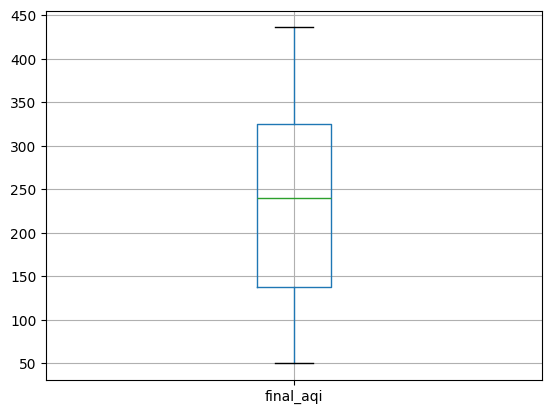

In [22]:
#handling outliers in data to adjust for unusual events
data.boxplot(column="final_aqi")
#as seen in boxplot -> no major outliers to handle.

In [25]:
#using seaborn & matplotlib for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

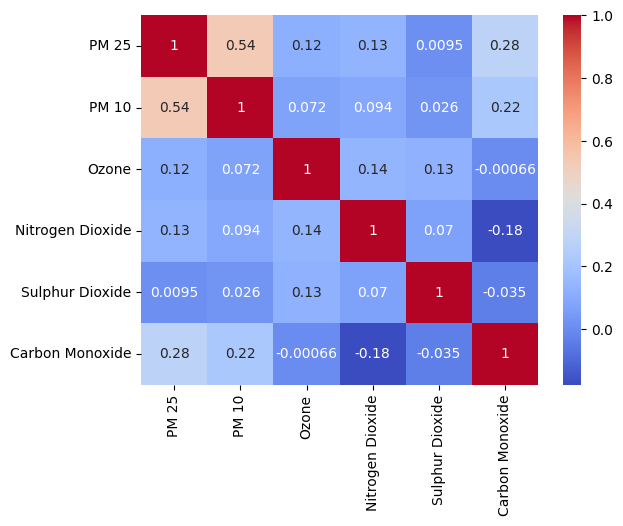

In [61]:
#a heatmap which displays the correlation of all the features
corr = data[["PM 25","PM 10","Ozone","Nitrogen Dioxide","Sulphur Dioxide","Carbon Monoxide"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

In [74]:
num_cols = ["PM 25","PM 10","Ozone","Nitrogen Dioxide","Sulphur Dioxide","Carbon Monoxide"]
monthly_mean = (data.groupby("Month", observed=True)[num_cols].mean().reset_index())

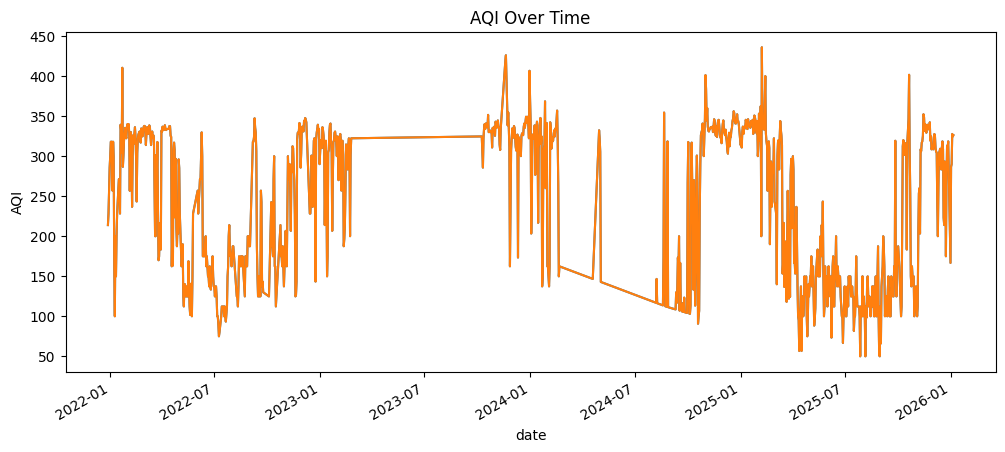

In [26]:
data["final_aqi"].plot(figsize=(12,5))
plt.title("AQI Over Time")
plt.ylabel("AQI")
plt.show()

In [34]:
#there is a flat line in middle showing constant interpolation -> can affect the model ?????
data["aqi_diff"] = data["final_aqi"].diff().abs()